In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os

import pandas as pd
from utils import * 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

#clear cuda memory

torch.cuda.empty_cache()

In [2]:
# Data augmentation and normalization for training
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# load data
data_dir = './CelebA_HQ_facial_identity_dataset/'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=12, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

class_names = train_dataset.classes
len(class_names)

Train dataset size: 4429
Test dataset size: 1267


310

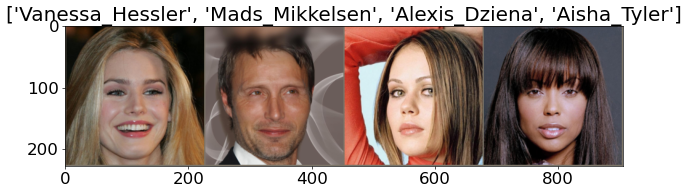

In [3]:
#define parameters for visualization
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

In [5]:
#load pre-trained model
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 310) # multi-class classification (num_of_class == 307)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

c:\ProgramData\Anaconda3\envs\SDS\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\SDS\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
num_epochs = 25
start_time = time.time()

train_history = pd.DataFrame(columns=['epoch', 'train_loss', 'train_acc', 'test_loss', 'test_acc'])

for epoch in range(num_epochs):
    """ Training Phase """
    model.train()

    running_loss = 0.
    running_corrects = 0

    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    train_loss = running_loss / len(train_dataset)
    train_acc = running_corrects.item() / len(train_dataset) * 100

    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, train_loss, train_acc, time.time() - start_time))

    """ Test Phase """
    model.eval()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        test_loss = running_loss / len(test_dataset)
        test_acc = running_corrects.item() / len(test_dataset) * 100
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, test_loss, test_acc, time.time() - start_time))
        
        train_history = pd.concat([train_history, pd.DataFrame([[epoch, train_loss, train_acc, test_loss, test_acc]], columns=['epoch', 'train_loss', 'train_acc', 'test_loss', 'test_acc'])], ignore_index=True)
# save the model



[Train #0] Loss: 5.5242 Acc: 4.0641% Time: 26.2780s
[Test #0] Loss: 4.9415 Acc: 10.7340% Time: 37.5597s
[Train #1] Loss: 4.3349 Acc: 22.3527% Time: 60.2259s
[Test #1] Loss: 3.9205 Acc: 25.2565% Time: 70.2074s
[Train #2] Loss: 3.2353 Acc: 47.1212% Time: 92.7682s
[Test #2] Loss: 3.2299 Acc: 41.9100% Time: 102.9793s
[Train #3] Loss: 2.3266 Acc: 68.1644% Time: 125.3637s
[Test #3] Loss: 2.8281 Acc: 49.4870% Time: 135.3302s
[Train #4] Loss: 1.6113 Acc: 82.5469% Time: 157.7738s
[Test #4] Loss: 2.2219 Acc: 61.7206% Time: 167.6450s
[Train #5] Loss: 1.0549 Acc: 92.0072% Time: 190.3551s
[Test #5] Loss: 1.8694 Acc: 66.2194% Time: 200.3026s
[Train #6] Loss: 0.6608 Acc: 96.6358% Time: 222.9696s
[Test #6] Loss: 1.7608 Acc: 68.9029% Time: 233.0026s
[Train #7] Loss: 0.4071 Acc: 98.8033% Time: 255.5064s
[Test #7] Loss: 1.4682 Acc: 73.5596% Time: 265.3796s
[Train #8] Loss: 0.2563 Acc: 99.5033% Time: 287.7918s
[Test #8] Loss: 1.3712 Acc: 76.6377% Time: 297.8992s
[Train #9] Loss: 0.1690 Acc: 99.8420% Time:

In [7]:
torch.save(model, 'models/model_310_plus_max_pro_ultra.pt')

# save the training history
train_history.to_csv('history/train_history_310_plus_max_pro_ultra.csv', index=False)


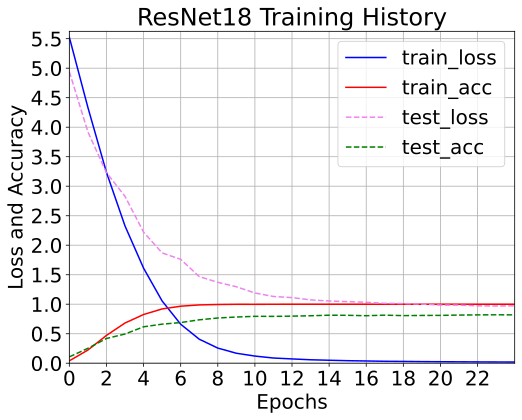

In [8]:
train_history = pd.read_csv('history/train_history_310_plus_max_pro_ultra.csv')
plot_history(train_history, 'ResNet18', 'history/train_history_310_plus_max_pro_ultra.svg')

In [10]:
model = torch.load('models/model_310_plus_max_pro_ultra.pt')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Evauation

[Prediction Result Examples]


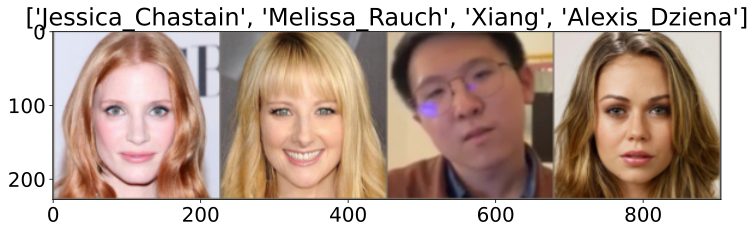

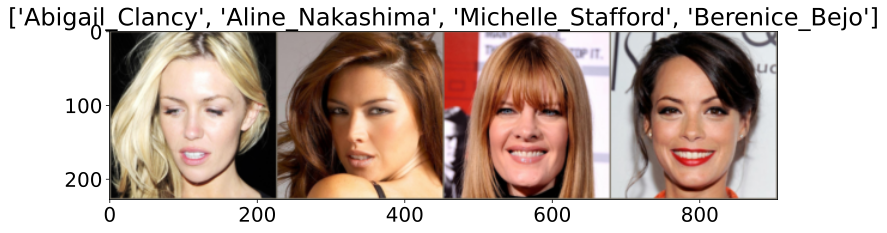

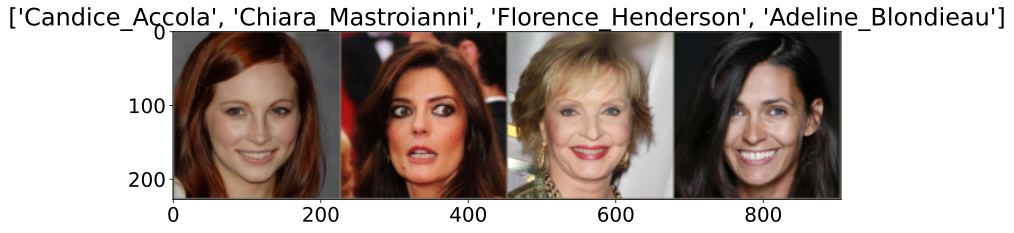

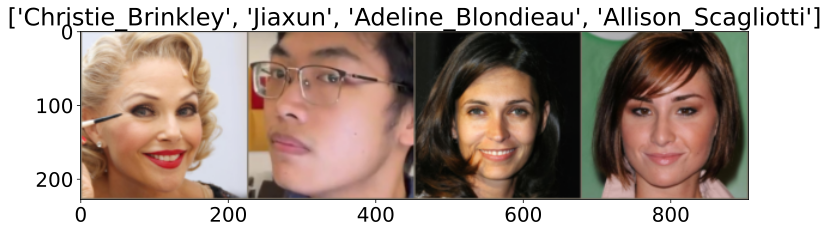

In [11]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])
            images = torchvision.utils.make_grid(inputs[8:12])
            imshow(images.cpu(), title=[class_names[x] for x in labels[8:12]])
            images = torchvision.utils.make_grid(inputs[12:16])
            imshow(images.cpu(), title=[class_names[x] for x in labels[12:16]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.

In [13]:
# write class names to json file
import json
with open('models/class_names_310.json', 'w') as f:
    json.dump(class_names, f)
